# Задача классификации

Для вопроизведения данных можно зафиксировать рандомные последовательности:

In [1]:
import torch
import random
import numpy as np

# random.seed(0) - фиксирует рандомную последовательность из библиотеку random с индексом 0
# np.random.seed(0) - из numpy
# torch.manual_seed(0) - при расчетам на  CPU
# torch.cuda.manual_seed(0) - на GPU
# torch.backends.cudnn.deterministic = True - переключает на детерминистический режим видеокарты, то есть запоминание данных с потерей скорости расчета
 
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Используем датасет wine из библиотеки sklearn.

Будет загружено 178 бутылок вин с 13 различными параметрами и 3 классами классификации.

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Разбиваем датасет на train и test и затем обернем в тензоры:

In [3]:
from sklearn.model_selection import train_test_split

# train_test_split(wine.data[:, :2], wine.target, test_size=0.3, shuffle=True)
# train_test_split - функция из библиотеки sklearn, формирующая выборки
# wine.data[:, :2] - используем 2 колонки параметров из 13 для удобства визуализации
# wine.target - то что предсказываем: номер класса
# test_size=0.3 - 30% уйдет в тест
# shuffle=True - перемшать чтобы не работала сортировка

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

# Дробные обернем во Float тензор
# Целые в Long тензор
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Нейронная сеть для классификации:

In [4]:
# self.sm = torch.nn.Softmax(dim=1) - передаем 3 выхода, соответствующих трем классам в функцию софтмакс, чтобы получить вероятности
# Функция forward(self, x) - реализует граф нейросети
# Функция inference(self, x) - реализует запуск софтмакса, не в forward потому что на выходе fc3 мы хотим посчитать кросс энтропию,
  # а она содержит log который взаимоуничтожится с exp из софтмакс. Софтмакс не нужен если мы хотим просто кросс-энтропию, но нужен,
  # если хотим вероятности.
# Softmax(dim=1) - означает что софтмакс применяется к матрице выходов построчно

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

Функция потерь: CrossEntropyLoss() - кросс-энтропия, которая использует выходы не после софтмакс, а сразу после выхода из нейронной сети.   

In [5]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

Batch - часть данных для которого считается loss, gradient descend, делается гадиентный шаг и только потом осуществляется переход к следующему batch. Это делается для того чтобы не хранить одновременно в памяти весь огромный датасет. Эпоха(просмотр всего датасета) таким образом, разбивается на много частей. 

In [6]:
#Делает случайное перемешивание
np.random.permutation(5)

array([2, 0, 1, 4, 3])

# Обучение нейросети:

In [7]:
# .forward - пропускает весь батч через нейросеть
# .float().mean() - среднее значение не можем посчитать у целочисленного тензора
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.4074)
tensor(0.4074)
tensor(0.4630)
tensor(0.5000)
tensor(0.4259)
tensor(0.4074)
tensor(0.5185)
tensor(0.5185)
tensor(0.4444)
tensor(0.4259)
tensor(0.5000)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.7407)
tensor(0.6852)
tensor(0.6481)
tensor(0.6852)
tensor(0.6667)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7222)
tensor(0.7037)
tensor(0.7407)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)


# Визуализация результатов обучения:

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


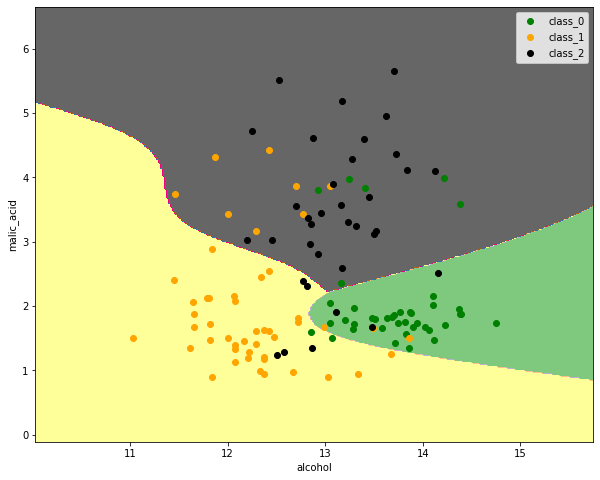

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Измените архитектуру так, чтобы на вход принимались все 13 признаков и проведите следующие эксперименты:

1. Поэкспериментируйте с количеством нейронов в скрытых слоях. Попробуйте поставить очень маленькое число. Существует ли пороговое значение количества скрытых нейронов, при котором обучение становится невозможным?

2. Попробуйте передавать различные значения test_size в функцию train_test_split. При каком значении test_size сеть предсказывает хуже чем Base Rate*? И какой Base Rate у датасета вин?

3. Зависит ли время обучения на одной эпохе от размера батча? Исследуйте эту зависимость.

Поделитесь своими выводами в комментариях :)

 

*Base Rate - значение accuracy для случая, когда модель для всех объектов предсказывает самый частотный класс в датасете

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :13], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [25]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [26]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [28]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.8148)
tensor(0.8148)
tensor(0.7593)
tensor(0.8704)
tensor(0.8889)
tensor(0.9259)
tensor(0.9444)
tensor(0.9074)
tensor(0.9259)
tensor(0.9444)
tensor(0.8889)
tensor(0.8704)
tensor(0.9259)
tensor(0.8889)
tensor(0.9259)
tensor(0.8889)
tensor(0.9259)
tensor(0.9259)
tensor(0.9259)
tensor(0.8704)
tensor(0.9444)
tensor(0.8519)
tensor(0.9259)
tensor(0.9444)
tensor(0.9074)
tensor(0.9074)
tensor(0.9074)
tensor(0.8889)
tensor(0.9074)
tensor(0.9259)
tensor(0.9444)
tensor(0.9074)
tensor(0.9444)
tensor(0.9074)
tensor(0.9074)
tensor(0.9444)
tensor(0.9444)
tensor(0.9074)
tensor(0.9074)
tensor(0.9444)
tensor(0.9259)
tensor(0.9444)
tensor(0.9074)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9259)
tensor(0.9444)
tensor(0.9259)
tensor(0.9444)
